# 1-1

EDA를 진행하고 (+시각화) , 차원축소의 필요성이 있는지 확인 (5점)

In [93]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p1.csv')
def resume(df):
    print(df.shape)
    tmp = pd.DataFrame()
    tmp['dtypes'] = df.dtypes
    tmp['결측치'] = df.isna().sum()
    tmp['유일값'] = df.nunique()
    tmp['첫번째'] = df.iloc[0,:]
    tmp['두번째'] = df.iloc[1,:]
    return tmp
resume(df)

(395, 12)


,dtypes,결측치,유일값,첫번째,두번째
sex,object,0,2,F,F
age,int64,0,8,18,17
pstatus,object,0,2,A,T
medu,int64,0,5,4,1
fedu,int64,0,5,4,1
guardian,object,0,3,mother,father
traveltime,int64,0,4,2,1
studytime,int64,0,4,2,2
failures,int64,0,4,0,0
freetime,int64,0,5,3,3


- 목적 : 학생의 다양한 주변 환경에 따른 결석 등급 (absences)
- 크게 부모의및보호자현황 (pstatus, medu, fedu, guardian), 입지 (traveltime, studytime), 개인현황(sex, age, failure, freetime) 으로 나뉜다.
- 수치형으로 되어있는 데이터도 전부 범주형에 속함
- <u>차원축소 시, 범주형의 수치값을 적용하므로 왜곡이 생길수 있음<u>

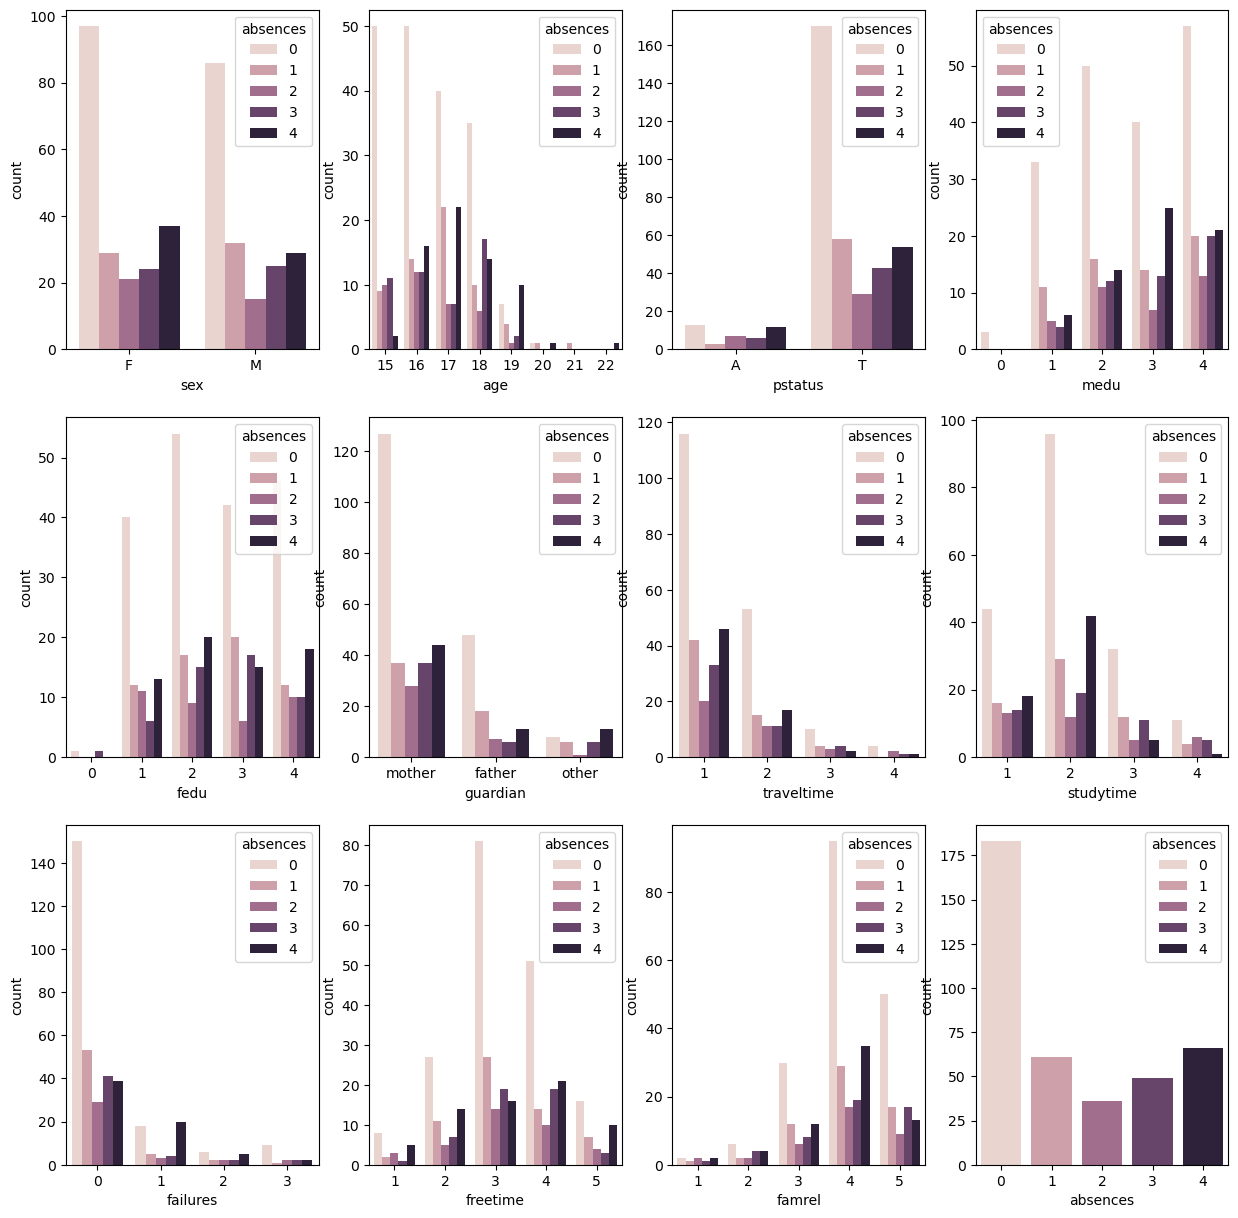

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns 
fig, ax = plt.subplots(3,4,figsize = (15,15))
for ax, col in zip(ax.flat, df.columns):
    sns.countplot(data=df, x=col, hue='absences', ax=ax);
    # df[col].value_counts().sort_index().plot(kind='bar', ax=ax, color = 'grey')

- absences에 따른 각 변수별 차이를 확인
    - 부모의 생존여부 및 studytime 등이 크게 영향 미치는 것 확인


In [95]:
pd.crosstab(df['absences'],df['medu'])

medu,0,1,2,3,4
absences,,,,,
0,3,33,50,40,57
1,0,11,16,14,20
2,0,5,11,7,13
3,0,4,12,13,20
4,0,6,14,25,21


# 1-2

데이터 품질 개선을 위한 방법이 있는지 찾고 데이터셋을 재생성하라 (5점)

In [96]:
from scipy.stats import chi2_contingency
cols = []
for col in df.columns[:-1]:
    tmp = pd.crosstab(df[col],df['absences'])
    _,p_val,_,_= chi2_contingency(tmp)
    if p_val<0.05: 
        if col != 'absences':
            statement = '결석률과 관련이 있다'
            cols.append(col)
        else : pass
    else : statement = '결석률과 관련이 없다'
    print(f'{col}는 p-value:{p_val}로 {statement}')

sex는 p-value:0.7930484454144936로 결석률과 관련이 없다
age는 p-value:0.001840496992289635로 결석률과 관련이 있다
pstatus는 p-value:0.01931591912939198로 결석률과 관련이 있다
medu는 p-value:0.4517558001251953로 결석률과 관련이 없다
fedu는 p-value:0.6736185670620628로 결석률과 관련이 없다
guardian는 p-value:0.01580475746030849로 결석률과 관련이 있다
traveltime는 p-value:0.8349934325072776로 결석률과 관련이 없다
studytime는 p-value:0.04439265786829646로 결석률과 관련이 있다
failures는 p-value:0.005994149777223442로 결석률과 관련이 있다
freetime는 p-value:0.48328809003780904로 결석률과 관련이 없다
famrel는 p-value:0.8404434032741234로 결석률과 관련이 없다


In [97]:
cols

['age', 'pstatus', 'guardian', 'studytime', 'failures']

In [114]:
from sklearn.model_selection import train_test_split
X = df[cols]
y = df['absences']
X_d = pd.get_dummies(X, drop_first= True)
X_train,X_test,y_train,y_test = train_test_split(X_d,y,test_size=0.2,stratify=y,random_state=0)

# 1-3

1.2에서 제시한 방법이 데이터 과적합이 된다는 가정하에 어떻게 해결할 수 있을지 2가지 개선안 제시, 각방법들의 장단점 기술 (10점)



- 변수선택법을 진행하며 차원의 수를 줄인다. 보다 중요한 변수를 선별적으로 선택한다.
    - 장점 : 간단한 방법으로 과적합 문제를 해결할 수 있다
    - 단점 : 변수 간/시기 간에도 영향을 받기 때문에, 상황/환경이 바뀌면 제외한 변수가 더 중요해지는 경우도 있다.
    - 단점을 보완하기 위해, 주기적으로 모델의 성능을 점검하며, 개선할 필요가 있다.
- 데이터를 추가로 확보한다. 
    - 장점 : 보다 많은 샘플을 확보하며, 과적합 및 데이터의 편향 문제를 개선할 수 있다.
    - 단점 : 데이터를 추가로 확보하기 위한 시간 및 자원이 소요된다.
    - 목적성 있는 기간동안 전략적으로 데이터를 확보하려는 노력이 필요하다.

# 2-1

1-2 데이터셋을 기준으로 random forest, neural network , lightgbm 3가지 방식으로 학교 결석 횟수등급을 예측하는 모델을 만들어라, f1 score로 모델을 평가하라 (5점)

In [121]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
import logging
from time import time
import lightgbm 
from lightgbm import LGBMClassifier
# LightGBM의 로그 레벨 설정
lightgbm.register_logger(logging.root)
logging.root.setLevel(logging.CRITICAL)

nn = MLPClassifier()
lgb = LGBMClassifier(verbose=0)
rf = RandomForestClassifier()

models = [rf,nn,lgb]
mns = ['random forest', 'neural network' , 'lightgbm']
for idx, model in enumerate(models):
    s = time()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    e = time()
    t = e-s
    print(f'===={mns[idx]}====')
    print(f'time:{t}')
    print(classification_report(y_test,y_pred))
    print()

====random forest====
time:0.11428403854370117
              precision    recall  f1-score   support

           0       0.55      0.59      0.57        37
           1       0.08      0.08      0.08        12
           2       0.20      0.14      0.17         7
           3       0.17      0.10      0.12        10
           4       0.31      0.38      0.34        13

    accuracy                           0.38        79
   macro avg       0.26      0.26      0.26        79
weighted avg       0.36      0.38      0.37        79


====neural network====
time:0.15122079849243164
              precision    recall  f1-score   support

           0       0.51      0.97      0.67        37
           1       0.00      0.00      0.00        12
           2       0.00      0.00      0.00         7
           3       0.50      0.10      0.17        10
           4       0.33      0.15      0.21        13

    accuracy                           0.49        79
   macro avg       0.27      0.25  

E:\miniconda\envs\tw311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
E:\miniconda\envs\tw311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\miniconda\envs\tw311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\miniconda\envs\tw311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defi

# 2-2
hard voting, soft voting에 대한 장단점을 설명하고 2-1의 3가지 모델로 구현하라. 두 방식의 f1-score를 비교하라 (10점)

소프트 보팅(Soft Voting)과 하드 보팅(Hard Voting)은 앙상블 학습 방법에서 개별 모델의 예측 결과를 결합하는 방식의 차이입니다.

1. 하드 보팅(Hard Voting)
- 개별 모델의 예측 결과를 다수결 원칙으로 결합합니다.
- 각 모델의 예측 결과를 모아 가장 많이 예측된 클래스를 최종 예측 결과로 선택합니다.
- 예를 들어, 세 개의 모델이 있고 각각 A, B, A를 예측했다면, 최종 예측 결과는 A가 됩니다.
- 하드 보팅은 분류 문제에서 주로 사용됩니다.

2. 소프트 보팅(Soft Voting)
- 개별 모델의 예측 확률(또는 신뢰도)을 평균하여 결합합니다.
- 각 모델의 예측 확률을 모아 평균을 내고, 그 평균값이 가장 높은 클래스를 최종 예측 결과로 선택합니다.
- 예를 들어, 세 개의 모델이 있고 각각 A에 대한 확률이 0.6, 0.7, 0.8이라면, 평균은 0.7이 되고 최종 예측 결과는 A가 됩니다.
- 소프트 보팅은 분류 문제뿐만 아니라 회귀 문제에서도 사용할 수 있습니다.

하드 보팅은 개별 모델의 예측 결과만을 고려하므로 단순하지만, 소프트 보팅은 예측 확률까지 고려하므로 더 정교한 결과를 얻을 수 있습니다. 그러나 소프트 보팅은 모든 모델이 예측 확률을 출력할 수 있어야 한다는 제약이 있습니다.

일반적으로 소프트 보팅이 하드 보팅보다 더 나은 성능을 보이지만, 모델의 특성과 데이터에 따라 적절한 방법을 선택해야 합니다. 또한 두 방법을 혼합하여 사용하는 것도 가능합니다.


In [119]:
from sklearn.ensemble import VotingClassifier
lightgbm.register_logger(logging.root)
logging.root.setLevel(logging.CRITICAL)
# 하드 보팅 분류기 생성
voting_clf = VotingClassifier(estimators=[('random forest', rf), ('neural network', nn), ('lightgbm', lgb)], voting='hard')

# 모델 학습
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
# 모델 평가
print(f'time:{t}')
print(classification_report(y_test,y_pred))

time:0.06309247016906738
              precision    recall  f1-score   support

           0       0.48      0.70      0.57        37
           1       0.11      0.08      0.10        12
           2       0.00      0.00      0.00         7
           3       0.25      0.10      0.14        10
           4       0.22      0.15      0.18        13

    accuracy                           0.38        79
   macro avg       0.21      0.21      0.20        79
weighted avg       0.31      0.38      0.33        79



E:\miniconda\envs\tw311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [120]:
from sklearn.ensemble import VotingClassifier
# 소프트 보팅 분류기 생성
s=time()
lightgbm.register_logger(logging.root)
logging.root.setLevel(logging.CRITICAL)
voting_clf = VotingClassifier(estimators=[('random forest', rf), ('neural network', nn), ('lightgbm', lgb)], voting='soft')

# 모델 학습
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
e=time()
# 모델 평가
t = e-s
print(f'time:{t}')
print(classification_report(y_test,y_pred))

time:0.18785858154296875
              precision    recall  f1-score   support

           0       0.50      0.76      0.60        37
           1       0.17      0.08      0.11        12
           2       0.25      0.14      0.18         7
           3       0.25      0.10      0.14        10
           4       0.22      0.15      0.18        13

    accuracy                           0.42        79
   macro avg       0.28      0.25      0.24        79
weighted avg       0.35      0.42      0.36        79



# 2-3
총 5개 모델(RF, NN, LGBM, 하드보팅, 소프트보팅) 중 실시간 온라인 시스템에 가장 적합한 모델과 선정이유를 객관적으로 제시하라 (5점)

- 실시간 온라인 시스템에는 속도 / 정확도 를 고려하여 선정
- 5개 시스템 모두 속도는 0.5초 이하로 속도상의 큰 문제는 없어보인다.
- NN을 활용한 모델이 성능면에서 가장우수하기에 활용을 하며,
- 데이터가 많이 쌓여서 속도 저하시 보다 빠른 lightGBM모델도 고려해볼만 하다.

# 3-1
적정 모델과 선정 및 모델링 과정에서 추가적으로 고려해볼 만한 사항은? (5점)

# 3-2
모델을 학교 시스템에 적용하여 활용하려한다. 모델 적용 및 운영과정에서 고려해볼 만한 사항? (5점)

# 4번

데이터 url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p4_.csv

status : 생존 여부 (death: 죽음 / event lost: 생존)

company : 회사구분

In [51]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p4_.csv')
resume(df)

(42, 3)


,dtypes,결측치,유일값,첫번째,두번째
time(month),int64,0,21,1,2
status,object,0,2,event lost,event lost
company,object,0,2,X,X


# 4-1
Kaplan Meier 방법 사용 생존분석 수행. 회사부품별 25, 35, 45 개월에서의 생존 확률 (소숫점 3자리 ,5점)

In [56]:
df['status_'] = df['status'].map({'event lost':0, 'death':1})

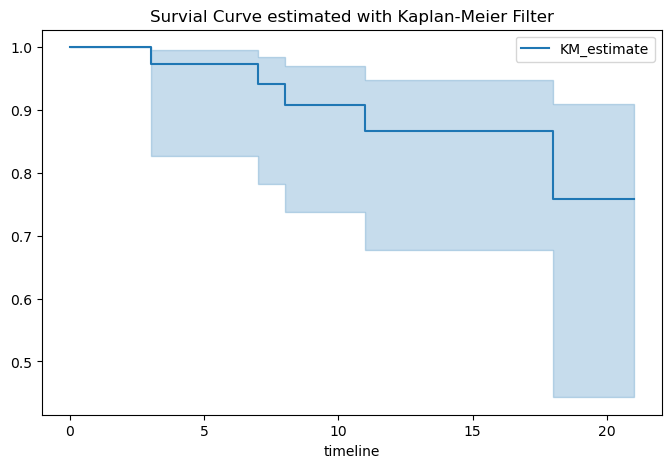

In [60]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(df['time(month)'], df['status_'])

# Survival Plot 그리기
kmf.plot_survival_function(figsize=(8,5))
plt.title('Survial Curve estimated with Kaplan-Meier Filter')
plt.show()

# 4-2
두 회사간 생존시간 차이를 log-rank 방식으로 검정하시오. 가설설정, 통계량, 귀무가설 기각여부 판단(10점)

In [66]:
from lifelines.statistics import logrank_test
con1 = (df.company == df.company.unique()[0])
con2 = (df.company == df.company.unique()[1])
logrank_test(df[con1]['time(month)'], df[con1]['time(month)'],\
             df[con2]['status_'], df[con2]['status_'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           0.00 1.00     -0.00

# 5번

데이터 url: https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p5_.csv

data형식

한 유저가 시식 전 물건 구매의사 유,무와 시식 후 구매의사 유,무에 대한 응답을 나타낸 데이터

{시식전} _ {구매의사 유 or 무} __ {시식후} _ {구매의사 유 or 무}

In [39]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p5_.csv')
resume(df)

(60, 2)


,dtypes,결측치,유일값,첫번째,두번째
data,object,0,4,시식전_유__시식후_유,시식전_유__시식후_유
userId,object,0,60,user_1,user_2


In [45]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p5_.csv')
df['시식전'] = df['data'].apply(lambda x : x.split('__')[0].split('_')[1]).map({'무':0,'유':1})
df['시식후'] = df['data'].apply(lambda x : x.split('__')[1].split('_')[1]).map({'무':0,'유':1})
df = df.drop('data',axis=1)
df.head(2)

,userId,시식전,시식후
0,user_1,1,1
1,user_2,1,1


# 5-1
시식여부가 구매의사에 영향을 주는지 가설을 설정하시오(5점)

In [49]:
'''
카이제곱검정을 통해 시식전과 시식후의 결과 변화이 있는지 확인
'''
H0 = '시식전과 시식후의 결과 변화가 없다'
H1 = '시식전과 시식후의 결과 변화가 있다'
print('귀무가설:',H0)
print('대립가설:',H1)


귀무가설: 시식전과 시식후의 결과 변화가 없다
대립가설: 시식전과 시식후의 결과 변화가 있다


# 5-2
검정하고 결과를 분석하시오(5점)

In [50]:
ct = pd.crosstab(df['시식전'], df['시식후'])
_,p_val,_,_ = chi2_contingency(ct)
print(f'p_value: {p_val}')
if p_val <0.05:    print(H1)
else:print(H0)

p_value: 0.3150334515411813
시식전과 시식후의 결과 변화가 없다


# 6-1
A,B 지역 학생의 점수에 차이가 있는지 가설을 설정하고 정하시오 (10점) 
dataurl : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p6.csv

In [67]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p6.csv')
resume(df)

(36, 3)


,dtypes,결측치,유일값,첫번째,두번째
score,float64,8,21,91.0,NaN
school_name,object,0,2,A,A
ID,int64,0,36,1,2


In [80]:
'''
서로 다른 두집단간 평균의 차이를 묻는 것으로, 표본의 갯수는 50개 이하이므로
정규성을 확인후 독립표본t검정을 진행한다
'''
from scipy.stats import ttest_ind
H0 = 'A,B 지역 학생의 점수에 차이가 없다'
H1 = 'A,B 지역 학생의 점수에 차이가 있다'

A = df.loc[df.school_name=='A','score'].dropna(axis=0).reset_index(drop=True)
B = df.loc[df.school_name=='B','score'].dropna(axis=0).reset_index(drop=True)
_,p_val= ttest_ind(A,B)
print(f'독립표본의 t검정 진행결과 pvalue는 {p_val:.6f}로')

if p_val<0.05:print(f'귀무가설을 기각한다. 즉, {H1}')
else: print(f'귀무가설을 기각하지 못한다. 즉, {H0}')

독립표본의 t검정 진행결과 pvalue는 0.021140로
귀무가설을 기각한다. 즉, A,B 지역 학생의 점수에 차이가 있다


# 7-1
몸무게를 제어한다고 생각하고, 나이와 콜레스테롤 상관계수 및 유의확률 구하라(10점)

데이터 출처 : https://www.kaggle.com/datasets/hangawqadir/erbil-heart-disease-dataset

데이터 url : https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p7.csv

연령, 몸무게,콜레스테롤 수치 데이터

In [81]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/28/p7.csv')
resume(df)

(333, 3)


,dtypes,결측치,유일값,첫번째,두번째
age,int64,0,59,65.0,54.0
Cholesterol,float64,0,154,69.0,117.0
weight,float64,0,92,111.0,81.0


In [87]:
df.corr()['weight'][:-1]

age           -0.062325
Cholesterol    0.206904
Name: weight, dtype: float64

- 몸무게는 나이보다 콜레스테롤과의 상관계수가 높다

# 7-2
상관계수를 유의수준 0.05하에서 검정하라 (5점)

In [92]:
import numpy as np
from scipy.stats import pearsonr
for col in df.columns[:-1]:
    # 예시 데이터
    x = df[col]
    y = df['weight']

    # 피어슨 상관계수 계산
    corr_coef, p_value = pearsonr(x, y)

    # 유의수준 0.05 하에서 검정
    alpha = 0.05
    print(f'{col}의 p_value : ',p_value)
    if p_value < alpha:
        print(f"{col}의 상관계수 {corr_coef:.2f}는 유의수준 {alpha}에서 유의미합니다.\n")
    else:
        print(f"{col}의상관계수 {corr_coef:.2f}는 유의수준 {alpha}에서 유의미하지 않습니다.\n")

age의 p_value :  0.2567295907424403
age의상관계수 -0.06는 유의수준 0.05에서 유의미하지 않습니다.

Cholesterol의 p_value :  0.00014314060248596513
Cholesterol의 상관계수 0.21는 유의수준 0.05에서 유의미합니다.

